In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../Share/')
import baseline, config

sys.path.append('../')
import self_supervised_v1

import warnings
warnings.filterwarnings('ignore')

SUBJECT = "Hunmin"
Threshold_K = 10
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
#trainer_Hunmin = baseline.ModelTrainer(config, subject="Hunmin")
trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

# 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
(68173, 4, 14, 1) (68173,) (17043, 4, 14, 1) (17043,)


In [2]:
def initialize_prototypes(model, X, y, num_classes=6):
    # 클래스별 prototype 계산
    prototypes = {}
    features = model.predict(X)
    for cls in range(num_classes):
        cls_features = features[y == cls]
        prototypes[cls] = np.mean(cls_features, axis=0)
    return prototypes


from sklearn.metrics.pairwise import cosine_similarity

def predict_with_prototypes(prototypes, features):
    # 각 feature에 대해 가장 유사한 prototype 선택
    preds = []
    proto_vectors = np.stack([prototypes[i] for i in sorted(prototypes.keys())])  # shape: [C, D]
    sims = cosine_similarity(features, proto_vectors)  # shape: [N, C]
    preds = np.argmax(sims, axis=1)
    return preds

def update_prototypes(prototypes, features, pseudo_labels, alpha=0.1):
    # pseudo_labels는 모델이 예측한 클래스
    for i, label in enumerate(pseudo_labels):
        prototypes[label] = (1 - alpha) * prototypes[label] + alpha * features[i]
    return prototypes


In [3]:
# 초기 설정
final_session = len(config.Info_sub_H)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model = self_supervised_v1.build_encoder_model()  # 분류기 없이 encoder만

# 초기 프로토타입 생성
prototypes = initialize_prototypes(model, X_init, y_init)

# Accuracy 저장 리스트
Proto_Update_Acc = []

for session in range(Threshold_K, final_session-1):
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    # feature 추출
    features = model.predict(X_test, verbose=0)

    # 예측 및 정확도 평가
    preds = predict_with_prototypes(prototypes, features)
    acc = np.mean(preds == y_test)
    Proto_Update_Acc.append(acc)

    # pseudo-label 사용하여 prototype 업데이트
    pseudo_labels = preds  # 모델 출력 기반
    features_train = model.predict(X_train, verbose=0)
    prototypes = update_prototypes(prototypes, features_train, pseudo_labels)


Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Returning K-th session data: Exp_2025-06-23-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-23-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-23-v3/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-23-v4/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-24-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-24-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-24-v3

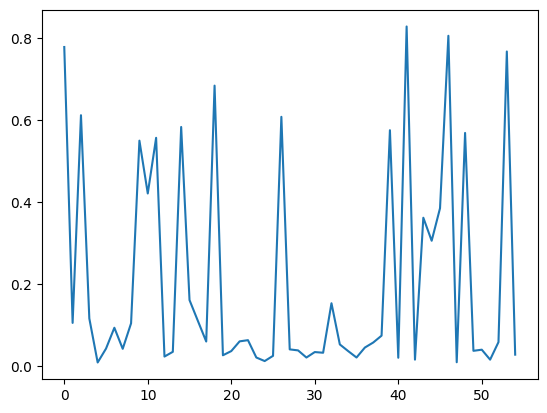

In [4]:
plt.plot(Proto_Update_Acc)
plt.show()

In [5]:
# Accuracy 저장 리스트
final_session = len(config.Info_sub_H)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model = self_supervised_v1.build_encoder_model()  # 분류기 없이 encoder만


# 초기 프로토타입 생성
prototypes = initialize_prototypes(model, X_init, y_init)

Proto_Fixed_Acc = []

for session in range(Threshold_K, final_session-1):
    _, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    features = model.predict(X_test, verbose=0)
    preds = predict_with_prototypes(prototypes, features)
    acc = np.mean(preds == y_test)
    Proto_Fixed_Acc.append(acc)


Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Returning K-th session data: Exp_2025-06-23-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-23-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-23-v3/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-23-v4/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-24-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-24-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-24-v3

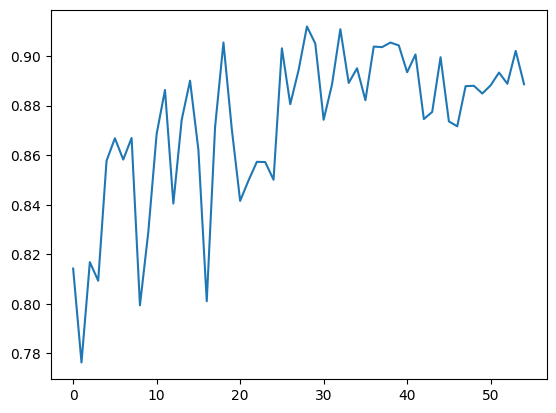

In [6]:
plt.plot(Proto_Fixed_Acc)
plt.show()